# Assignment 1

**Due to**: 20/12/2021 (dd/mm/yyyy)

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Part-of Speech (POS) tagging as Sequence Labelling using Recurrent Neural Architectures

**Authors**: 

*   Davide Mercanti: davide.mercanti@studio.unibo.it
*   Riccardo Fava: riccardo.fava6@studio.unibo.it
*   Luca Bompani: luca.bompani4@studio.unibo.it

## Downloading the dataset and some utilities

In [1]:
# This cell includes some utilities that are used in the rest of the notebook.

from os.path import isfile, isdir, join as path_join
from google.colab import drive
from shutil import unpack_archive, copy
from torch.utils.data import Dataset
import pickle
import pandas as pd
from collections import defaultdict


def try_get_from_Drive(fname, dpath):
  try:
    if not isdir('/content/drive'): drive.mount('/content/drive')
    if isfile(f'{dpath}{fname}'):
      print('=== Zip found in Google Drive ===')
      copy(f'{dpath}{fname}','.')
  except Exception:
    pass
  
def try_copy_in_Drive(fname, dpath):
  try:
    if not isdir('/content/drive'): drive.mount('/content/drive')
    if not isfile(f'{dpath}{fname}'):
      print('=== copying in Drive ===')
      copy(fname,f'{dpath}{fname}')
  except Exception as e:
    print(e)
    
def unpickle(fname, verbose=False):
    with open(fname, 'rb') as pf:
        if verbose: print(end='loading pickled file... ', flush=True)
        loaded = pickle.load(pf, encoding='bytes')
        if verbose: print('done')
        return loaded


class autoIntDict(defaultdict):
  ''' Similar to a default dictionary with int values, but keeps count of the newly added
  elements. Accessed elements are automatically added in the dictionary if nonexistent
  with a value that is len(current_dict). For example, given:
    orig = {'ciao':0, 'pippo':1}
    prova = myDict(orig)
    prova['ciao'], prova['hello'], prova['man'], prova.get_newly_added(), prova['man'], prova['ball'], prova
  The last line evaluates to:
    (0, 2, 3, 2, 3, 4, myDict(None, {'ball': 4, 'ciao': 0, 'hello': 2, 'man': 3, 'pippo': 1}))
  '''
  def __init__(self, *aa, **aak):
    self.newly_added = 0
    self.base_len = len(aa[0])
    return super().__init__(None, *aa, **aak)

  def __missing__(self, unused):
    self.newly_added += 1
    return self.setdefault(self.key, self.base_len + self.newly_added -1)

  def __getitem__(self, key):
    self.key = key
    return super().__getitem__(key)

  def get_newly_added(self):
    tmp = self.newly_added
    self.base_len += tmp
    self.newly_added = 0
    return tmp

# Defining custom Dataset class for better handling data using Pytorch
# It expects df to have two columns!
class CustomTextDataset(Dataset):
  def __init__(self, df):
    self.text = df.iloc[:,0]
    self.labels = df.iloc[:,1]
  
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, idx):
    return (self.labels[idx], self.text[idx])

In [ ]:
# These 2 cells download the data as a zipfile and copy it in Drive, then local
# zip is extracted. Every operation is performed only if needed.

In [2]:
DR_PATH = '/content/drive/MyDrive/'
USE_PICKLED = True

import os, sys
from os.path import isfile, isdir, join as path_join
from requests import get
from shutil import unpack_archive
from google.colab import drive

if not isdir('/content/drive'): drive.mount('/content/drive')
!mkdir /content/drive/MyDrive/gensim-data/ 2>/dev/null


Mounted at /content/drive


In [3]:
DIRNAME = 'dependency_treebank'
ZIPNAME = f'{DIRNAME}.zip'
URL = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

if not isfile(ZIPNAME): try_get_from_Drive(ZIPNAME, DR_PATH)
if not isfile(ZIPNAME):
  print(end='=== Downloading... ', flush=True)
  with open(ZIPNAME, 'wb') as outf: outf.write(get(URL).content)
  print('=== OK ===')
  try_copy_in_Drive(ZIPNAME, DR_PATH)
else: print('no download needed')
  
if not isdir(DIRNAME):
  unpack_archive(ZIPNAME)
  print('=== Unpacked ===')
else: print('no unpacking needed')

del get

=== Zip found in Google Drive ===
no download needed
=== Unpacked ===


## Splitting the dataset structuring dataframes

In [4]:
import pandas as pd

In [5]:
def train_valid_test():
  '''Returns three dataframes with train, validation and test data respectiv.'''
  global DIRNAME

  def parse_file(file_):
    '''Returns an iterator of tuples, one for each nonempty line of 'file_', each
    one containing a token and its correspondent tag.'''
    for line in file_.readlines():
      try: token, tag, _ = line.split()
      except ValueError: pass # to exclude blank lines
      yield (token, tag)

  def df_from_files(*bounds):
    '''Builds a dataframe for every interval of files passed using parse_file.
    Returns a generator of the said dataframes. '''
    for t in bounds:
      file_tt :list[tuple] = [] # list of (token,tag) tuples
      for fnumber in range(*t):
        with open(path_join(DIRNAME, f'wsj_{fnumber:04}.dp'), 'r') as doc:
          file_tt += parse_file(doc)
      yield file_tt

  return tuple(
    pd.DataFrame(_, columns=['token','tag']) 
    for _ in df_from_files((1,101), (101,151), (151,200))
  )
  
train_df, test_df, val_df = train_valid_test()

N_OUT_FEATURES = len(pd.unique(train_df['tag']))
f'{N_OUT_FEATURES} out features'

'45 out features'

In [6]:
train_df.head(5)

,token,tag
0,Pierre,NNP
1,Vinken,NNP
2,",",","
3,61,CD
4,years,NNS


## Loading Pre-Trained Glove Model

In [7]:
GENSIM_PATH = '/content/drive/MyDrive/gensim-data'  # ASSUMED TO BE IN DRIVE

In [8]:
def load_glove_model(embedding_dimension):
  '''Loads a pre-trained word embedding model via gensim library, or unpickles
  the pre-saved file (faster) whenever available.'''
  global GENSIM_PATH, USE_PICKLED
  import gensim.downloader as gloader
  
  download_path = f'glove-wiki-gigaword-{embedding_dimension}'

  try:
    pic_name = path_join(GENSIM_PATH, download_path+'_pic')
    if USE_PICKLED and isfile(pic_name):
      embedding_model = unpickle(pic_name)
    else:
      if isdir('/content/drive'): 
        gloader.base_dir = GENSIM_PATH
      embedding_model = gloader.load(download_path)
      if USE_PICKLED:
        with open(pic_name, 'wb') as pf:
          print('dumping pickle file')
          pickle.dump(embedding_model, pf)
  except ValueError as e:
        print("Check the embedding dimension: (50, 100, 200, 300)")
        raise e
  return embedding_model

In [9]:
EMBEDDING_DIMENSION = 200
glove_embedding_model = load_glove_model(EMBEDDING_DIMENSION)

In [10]:
!ls /content/drive/MyDrive/gensim-data/

glove-wiki-gigaword-200  glove-wiki-gigaword-200_pic


## Checking for Out-of-vocabulary terms
We check the number of out-of-vocabulary terms in the training set. 

In [11]:
def check_OOV_terms(embedding_model, vocabulary_terms):
  '''Returns a list of out-of-vocabulary (OOV) terms and the corresp. len'''
  embedding_vocabulary = set(embedding_model.vocab.keys())
  oov = set(vocabulary_terms).difference(embedding_vocabulary)
  return list(oov), len(oov)

In [12]:
train_vocabulary_terms = train_df['token']
train_vocabulary_terms_tl = train_df['token'].map(str.lower)

_, n_oov_terms = check_OOV_terms(glove_embedding_model, train_vocabulary_terms)
print(f"Total OOV terms: {n_oov_terms} ({n_oov_terms/len(train_vocabulary_terms):.03f}%)")

_, n_oov_terms2 = check_OOV_terms(glove_embedding_model, train_vocabulary_terms_tl)
print(f"Total OOV terms after lowering: {n_oov_terms2} ({n_oov_terms2/len(train_vocabulary_terms):.03f}%)")

train_vocabulary_terms = train_vocabulary_terms_tl

Total OOV terms: 2346 (0.048%)
Total OOV terms after lowering: 359 (0.007%)


## Building Embedding Matrix and handling OOV terms
We proceed on building the embedding matrix, while handling OOV terms at the same time.
We will assign a random vector to each OOV term.
An alternative would be to identify the word embedding as the mean of its neighbour word embeddings.
We will use our embedding matrix as input for the embedding layer of our model.

In [13]:
from collections import defaultdict
import numpy as np

In [14]:
WORD_TO_POSITION_DICTIONARY = {}

for i,word in enumerate(glove_embedding_model.vocab):
    WORD_TO_POSITION_DICTIONARY[word] = i
    
WEIGHT_MATRIX = np.array([glove_embedding_model.get_vector(i) for i in WORD_TO_POSITION_DICTIONARY])

print(f'Weights matrix size: {WEIGHT_MATRIX.shape}')

Weights matrix size: (400000, 200)


## Data Iterators and data conversion

We have to convert our input text and our labels into numerical format.


In [15]:
import pandas as pd

In [16]:
def train_valid_test():
  '''Returns three datasets with train, validation and test data respectiv. '''
  
  def parse_file(file_):
    '''Returns an iterator of tuples, one for each nonempty line of 'file_', each
    one containing a token and its correspondent tag.'''
    labelled_sentences, labelled_sentence = [], []
    for line in file_.readlines() + ['']:
      try:
        token, tag, _ = line.split()
        labelled_sentence.append((token,tag))
      except ValueError: # Generated when end-of-sentence is encountered
        labelled_sentences.append(zip(*labelled_sentence))
        labelled_sentence = []
    yield labelled_sentences

  def df_from_files(*bounds):
    '''Builds a dataframe for every interval of files passed using parse_file.
    Returns a generator of the said dataframes. '''
    for t in bounds:
      file_tt :list[tuple] = []
      for fnumber in range(*t):
        with open(path_join(DIRNAME, f'wsj_{fnumber:04}.dp'), 'r') as doc:
         for _ in parse_file(doc): file_tt += _
      yield file_tt

  return tuple(
    pd.DataFrame(_, columns=['sentence','POS']) 
    for _ in df_from_files((1,101), (101,151), (151,200))
  )

train_df, val_df, test_df = train_valid_test()


In [17]:
import torch
import torchtext
from torch.utils.data import Dataset, DataLoader
from torch import tensor
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import one_hot
from warnings import warn

np.random.seed(seed=33)

DEVICE = 'cpu'  # torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'USING DEVICE: {DEVICE}')

USING DEVICE: cpu


In [18]:
WORD_TO_POSITION_DEFDICT = autoIntDict(WORD_TO_POSITION_DICTIONARY)

def update_mat_with_random_(n:int):
  ''' Updates WEIGHT_MATRIX inplace by adding it n random vectors (appending
  them to the 1st dimension.) '''
  global WEIGHT_MATRIX, EMBEDDING_DIMENSION
  n_random_embedding = np.random.uniform(low=-0.05, high=0.05, size=(n,EMBEDDING_DIMENSION))
  WEIGHT_MATRIX = np.concatenate((WEIGHT_MATRIX, n_random_embedding))

def apply_conversion(df, one_hot_dictionary=None, add_ = 0):
  '''
  Encodes a dataframe where each row looks like:
    (Pierre, Vinken, ,, 61 ...  (NNP, NNP ...
  by applying an incremental encoding to the 1st column (as possibly specified
  by one_hot_dictionary) and a one-hot encoding to the 2nd:
    [5029, 400000, 1, 4978 ...  [[tensor(0.,...), tensor(0.,...) ...
  '''
  global WORD_TO_POSITION_DEFDICT, N_OUT_FEATURES

  def one_hot_pos(df_series, one_hot_dictionary=None):
      """
      take a series of lists as the input data and one hot encodes based on the
      number of unique values in the whole series
      """    
      dic_values = \
        one_hot_dictionary if one_hot_dictionary \
        else {word:number for number,word in enumerate({ j for i in df_series for j in i })}

      df_local = df_series.map(lambda _: tensor([dic_values[i] for i in _]))
      df_local_one_hot = df_local.map(lambda x:one_hot(x, N_OUT_FEATURES).to(torch.float16))
      return df_local_one_hot, dic_values

  col1 = df.iloc[:,0].apply(lambda _: [WORD_TO_POSITION_DEFDICT[l.lower()]  for l in _ ])
  col2, dic = one_hot_pos(df.iloc[:,1], one_hot_dictionary if one_hot_dictionary else None)
  encoded_df = pd.DataFrame(zip(col1,col2), columns=df.columns)

  update_mat_with_random_(WORD_TO_POSITION_DEFDICT.get_newly_added() + add_)  # +1 for <<UNK>> (use -1 to access)
  
  return (encoded_df, (None if one_hot_dictionary else dic))

Here we add the out of vocabulary terms to WORD_TO_POSITION_DEFDICT and a correspondent random embedding in WEIGHT_MATRIX.

Note that this is done for the **training set** and for the **validation set**, but not for the test set here.

In [19]:
encoded_train_df, one_hot_dictionary = apply_conversion(train_df)
print(f'from {len(WORD_TO_POSITION_DICTIONARY)} to {len(WORD_TO_POSITION_DEFDICT)}')

encoded_val_df,   _                  = apply_conversion(val_df,one_hot_dictionary)
print(f'then to {len(WORD_TO_POSITION_DEFDICT)}')

if len(WORD_TO_POSITION_DICTIONARY)==len(WORD_TO_POSITION_DEFDICT):
  warn('Nothing added! For this cell to be effective, re-run everything!')

WORD_TO_POSITION_DICTIONARY = WORD_TO_POSITION_DEFDICT

from 400000 to 400359
then to 400548


In [20]:
# Defining training, validation and test Dataset objects

BATCH_SIZE = 1

datasets = [CustomTextDataset(_) for _ in (encoded_train_df, encoded_val_df)]  #,encoded_test_df

train_dataset, val_dataset = datasets  #,test_dataset

train_dataloader, val_dataloader = \
  (DataLoader(_, batch_size=BATCH_SIZE, shuffle=False) for _ in datasets)  #,test_dataloader

## Training functions and class weights

### Computation of the class weights

In [21]:
tag_per_class_dict = { _ : 0 for _ in one_hot_dictionary.keys()}
for tags in train_df['POS']:
   for t in tags:
     for key in tag_per_class_dict.keys():
      if t == key: tag_per_class_dict[t] += 1
total_elem = np.sum(list(tag_per_class_dict.values()))

reversed_dict = {value : key for (key, value) in one_hot_dictionary.items()}
elem_per_class = np.zeros(N_OUT_FEATURES)
for key in tag_per_class_dict.keys():
  for i in range(len(reversed_dict)):
    if key == reversed_dict[i]: elem_per_class[i] = tag_per_class_dict[key]

CLASS_WEIGHTS = (total_elem/(elem_per_class*N_OUT_FEATURES))

CLASS_WEIGHTS.shape

(45,)

### Training and evaluation functions

In [22]:
import time, string
from sklearn.metrics import f1_score

PUNCT = set(string.punctuation) 
no_punct_labels = [_ for k, _ in one_hot_dictionary.items() if not set(k).issubset(PUNCT)]

# converts on-the-fly a tensor of probabilities into a one-hot representation, 3rd-dimension-wise:
labels_2_onehot = lambda _ : one_hot(_.argmax(2), N_OUT_FEATURES).to(torch.float16)

# Computes the n. of correct predictions, given  two 3d tensors, the predictions and the gold standard.
n_correct_predicts = lambda oh_predicted, oh_gold : (oh_predicted.argmax(2) == oh_gold.argmax(2)).sum().item()

def train(dataloader, model, optimizer, epoch=None, criterion=torch.nn.CrossEntropyLoss(), verbose=True):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()
    losses = []

    for idx, (label, text) in enumerate(dataloader):
        optimizer.zero_grad()                                     # Zeros the gradient that are accumulated by default
        predicted_label = model(text)                             # Will call 'forward' method of the model
        if predicted_label.shape[1]<=1:
          continue
        loss = criterion(predicted_label.squeeze(),
                         label.squeeze().max(dim=1)[1])           # Use loss.item() to visualize 
        loss.backward()                                           # Computes the gradients
        losses.append(loss.item())        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)   # Gradient clipping
        optimizer.step()                                          # Updates parameters
        predicted_label2 = labels_2_onehot(predicted_label)
        total_acc += n_correct_predicts(predicted_label2, label)
        total_count += label.size(dim=1)                          

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            if verbose:
              print(f'| epoch {(epoch if epoch else 0):3d} | {idx:5d}/{len(dataloader):5d} batches | accuracy { total_acc/total_count:8.3f}')
            total_acc, total_count = 0, 0
            start_time = time.time()
            
    return losses, total_acc/total_count

def evaluate(dataloader, model, criterion=torch.nn.CrossEntropyLoss(), retain=False):
    ''' Evaluates 'model' over the dataloader.
      Returns the history of the loss values and the tag-level accuracy.
    '''
    global labels_2_onehot
    model.eval()
    accumulated_good_pred, total_count = 0, 0
    val_steps = 0.0, 0
    accumulated_loss, history = [], []
    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model(text)
            if predicted_label.shape[1]<=1:
              continue
            loss = criterion(predicted_label.squeeze(), label.squeeze().max(dim=1)[1]) 
            m = labels_2_onehot(predicted_label)
            accumulated_good_pred += n_correct_predicts(m, label)
            total_count += label.size(dim=1)
            accumulated_loss.append(loss.item())
            if retain:
              y_true = label.argmax(2).numpy()[0]
              y_pred = m.argmax(2).numpy()[0]
              history += zip(y_true, y_pred)
    return accumulated_loss, accumulated_good_pred/total_count, history

### Training loop

In [23]:
def get_metric_only_tbi(labels_and_pred_accum, tbi, metric, additional_pars=([],{})):
    '''Given a list of tuples <y_true, y_pred> in labels_and_pred_accum, computes a
    metric/function only including in the computation all the couples that include in one
    of the two positions a label present in tbi (to be included). '''
    labels_accum, pred_accum = zip(*labels_and_pred_accum)
    masked_labels = np.isin(labels_accum, tbi)
    masked_pred   = np.isin(pred_accum,   tbi)
    y_true = np.array(labels_accum)[np.logical_and(masked_labels, masked_pred)]
    y_pred = np.array(pred_accum)  [np.logical_and(masked_labels, masked_pred)]
    return metric(y_true, y_pred, *additional_pars[0], **additional_pars[1])

def get_f1_score(labels_and_pred_accum, tbe):
    ''' starting from a list of couples (y_true, y_pred), computes the macro-avg
    f1-score ignoring the labels in tbe (to be excluded) both in y_true and y_pred
    '''
    return get_metric_only_tbi(labels_and_pred_accum, tbe, f1_score, ([],{'average':'macro'}))

In [24]:
def train_loop(
    create_model,
    train_dataloader,
    val_dataloader,
    params = {'hidden': 256, 'LR_Adam': 0.0001},
    criterion = torch.nn.CrossEntropyLoss(),
    scheduler_ = torch.optim.lr_scheduler.StepLR,
    create_optimizer = 'default',
    scheduler_parr = {'step_size': 8, 'gamma':.1},
    epochs = 20,
    early_stop_patience = 3,
    verbose = False,
    return_last_checkpoint = False
):
  global train, evaluate, no_punct_labels
  highlight = lambda _:f'{"-"*(len(_)+4)}\n  {_}\n{"-"*(len(_)+4)}'
  try:
      model = create_model(hidden=params['hidden'])
      if create_optimizer=='default':
        create_optimizer = lambda model_pars: torch.optim.Adam(model_pars, lr=0.0001)
      optimizer = create_optimizer(model.parameters())
      scheduler = scheduler_(optimizer = optimizer, **scheduler_parr)
      total_accu = None
      last_loss = 100
      trigger_times = 0
      metrics = {'train_loss': [],
                  'val_loss': [],
                  'train_loss_hist': [],
                  'train_acc': [],
                  'val_acc': [],
                  'f1_score': 0}

      for epoch in range(1, epochs + 1):
          epoch_start_time = time.time()
          losses_train, accu_train = train(train_dataloader, model, optimizer, verbose=verbose, criterion=criterion, epoch=epoch)
          loss_vals, accu_val, hist = evaluate(val_dataloader, model, criterion=criterion, retain=True)
          current_val_loss = np.mean(loss_vals)

          metrics['train_loss'].append(np.mean(losses_train))
          metrics['val_loss'].append(current_val_loss)
          metrics['train_loss_hist'].append(losses_train)
          metrics['train_acc'].append(accu_train)
          metrics['val_acc'].append(accu_val)

          if total_accu is not None and total_accu > accu_val:
            scheduler.step()
          else: total_accu = accu_val
          if verbose:
            print(highlight(f'| end of epoch {epoch:3d} | time: {time.time() - epoch_start_time:5.2f}s | '
              f'valid accuracy {accu_val:8.3f} | valid loss:{current_val_loss:8.3f}'))
          else:
            print(end=f"\rDoing epoch: {epoch:2}", flush=True)
          
          #Early stopping
          if current_val_loss > last_loss:
            trigger_times += 1
            if trigger_times >= early_stop_patience:
              print("\n === Early Stopping ===\n")
              metrics['f1_score'] = get_f1_score(hist, no_punct_labels)
              print("\rVal_accuracy: ", accu_val, ' - F1-score: ', metrics['f1_score'])
              break
          else:  trigger_times = 0
          last_loss = current_val_loss

          if epoch==epochs:
            metrics['f1_score'] = get_f1_score(hist, no_punct_labels)
            print("\rVal_accuracy: ", accu_val, ' - F1-score: ', metrics['f1_score'])
      print()
  #except KeyboardInterrupt:
  #    print('\n === Manually aborted ===')
  except Exception: raise
  finally:
      if return_last_checkpoint:
        cp = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }
        return model, metrics, cp
      else: return model, metrics

### Print plots function

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

def print_plots(metrics, complete_loss=False, size=(20,7)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(*size)

    ax1.plot(metrics['train_loss'], '.-')
    ax1.plot(metrics['val_loss'], '.-')
    ax1.grid(True)
    if complete_loss:
      ax1.plot(metrics['train_loss_hist'], '.')
      ax1.set_ylim(0, np.max(metrics['train_loss_hist'])*1.1)
    else:
      ax1.set_ylim(0, np.max(metrics['val_loss']+metrics['train_loss'])*1.1)
    ax1.set_title('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epochs')
    ax1.set_xticks(range(len(metrics['train_loss'])))
    leg_lab = ['train_loss', 'val_loss']
    ax1.legend(leg_lab + ['train_complete_loss'] if complete_loss else leg_lab,
               loc='upper right')
    m1, m2 = np.max(metrics['train_acc']), np.max(metrics['val_acc'])
    ax2.axhline(y=m1, color='gray', linestyle='-.')
    ax2.axhline(y=m2, color='gray', linestyle='-.')
    ax2.plot(metrics['train_acc'], '.-')
    ax2.plot(metrics['val_acc'], '.-')
    ax2.set_title('model accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epochs')
    ax2.set_xticks(range(len(metrics['train_loss'])))
    ticks_ = list(ax2.get_yticks())+[m1,m2]
    ax2.set_yticks(ticks=ticks_)
    ax2.set_yticklabels([f'{_:.2}' for _ in ticks_])
    ax2.grid(True)
    ax2.legend(['train_acc', 'val_acc'], loc='lower right')
    plt.show()

### Hyperparameter tuning functions

In [26]:
def tune(
    create_model,
    train_dataloader,
    val_dataloader,
    param_dict,
    criterion=torch.nn.CrossEntropyLoss(),
    scheduler_ = torch.optim.lr_scheduler.StepLR,
    scheduler_parr = {'step_size':8, 'gamma':.1},
    epochs = 12,
    early_stop_patience = 3,
    verbose = False
):
  global train, evaluate
  results = pd.DataFrame(columns=list(param_dict.keys()) + ["val_accuracy"] + ["F1_score"])
  try:
    for opt in param_dict['optimizer']:
        for LR in param_dict['learning_rate'][opt]:
            for hidden in param_dict['hidden_size']:
                model = create_model(hidden=hidden)
                optimizer = torch.optim.Adam(model.parameters(), lr=LR) if opt=="Adam" else torch.optim.SGD(model.parameters(), lr=LR)
                scheduler = scheduler_(optimizer = optimizer, **scheduler_parr)
                total_accu = None
                last_loss = 100
                trigger_times = 0
                print(f"Optimizer: {opt} | LR = {LR} | Hidden_size = {hidden}")
                for epoch in range(1, epochs + 1):
                    epoch_start_time = time.time()
                    train(train_dataloader, model, optimizer, verbose=verbose, criterion=criterion)
                    loss_vals, accu_val, labels_and_pred_accum = evaluate(val_dataloader, model, criterion=criterion, retain=True)
                    current_val_loss = np.mean(loss_vals)
                    if total_accu is not None and total_accu > accu_val:
                      scheduler.step()
                    else: total_accu = accu_val
                    print(end=f"\rDoing epoch: {epoch:2}", flush=True)
                    if epoch==epochs: 
                      final_f1_score = get_f1_score(labels_and_pred_accum)
                      print(f"\rVal_accuracy: {accu_val}, F1-score: {final_f1_score}")
                      results = results.append({"optimizer": opt, "learning_rate": LR, "hidden_size": hidden, "val_accuracy": accu_val,\
                                                "F1_score": final_f1_score}, ignore_index=True)
                    #Early stopping
                    if current_val_loss > last_loss:
                      trigger_times += 1
                      if trigger_times >= early_stop_patience:
                        final_f1_score = get_f1_score(labels_and_pred_accum)
                        results = results.append({"optimizer": opt, "learning_rate": LR, "hidden_size": hidden, "val_accuracy": accu_val,\
                                                "F1_score": final_f1_score}, ignore_index=True)
                        print(f"Val_accuracy: {accu_val}, F1-score: {final_f1_score}")
                        print(" === Early Stopping === ")
                        break
                    else:  trigger_times = 0
                    last_loss = current_val_loss
                print()
  except KeyboardInterrupt:
    print('\n === Manually aborted, returning results so far. ===')
  finally:
    return results

## Baseline Model (Bi-LSTM + FC) and Utilities



### Utility functions

In [27]:
def set_requires_grad_for_layer(layer, train):
    """ Sets the attribute 'requires_grad' to True or False (as specified by
    train) for each parameter in 'layer'. """
    for p in layer.parameters():
        p.requires_grad = train

### Model definition

In [30]:
import torch.nn as nn

class Base_RCNN (nn.Module):
    ''' NN that includes: a non-trained embedding, a LSTM module and a FC layer.'''
    
    def __init__(self, n_output, hidden=32, **_): 
      global WEIGHT_MATRIX
      super(Base_RCNN, self).__init__()
      self.embedding = nn.Embedding(*WEIGHT_MATRIX.shape)  
      self.embedding.weight = nn.Parameter(torch.from_numpy(WEIGHT_MATRIX))
      set_requires_grad_for_layer(self.embedding, False)
      self.lstm = nn.LSTM(  
          input_size=WEIGHT_MATRIX.shape[1],
          hidden_size=hidden,
          bidirectional=True,
          batch_first=True # If True, in and out tensors are provided as (batch,seq,feature), vs (seq,batch,feature)
      )
      self.fc = nn.Linear(in_features=hidden*2, out_features=n_output)
      
    def forward(self,x):
      "forward pass of the NN the only input must be an iterable of words"
      x = self.embedding(tensor(x))
      x, _ = self.lstm(torch.reshape(x,(1,*x.size())).to(torch.float32))
      return self.fc(x)

    def update_embeddings(self):
      ''' To re-align the (non-trainable!) embedding layer and WEIGHT_MATRIX.'''
      self.embedding = nn.Embedding(*WEIGHT_MATRIX.shape)  
      self.embedding.weight = nn.Parameter(torch.from_numpy(WEIGHT_MATRIX))
      set_requires_grad_for_layer(self.embedding, False)

### HP tuning

In [ ]:
'''results = tune(
    lambda **pp: Base_RCNN(N_OUT_FEATURES, **pp),
    train_dataloader,
    val_dataloader,
    { "optimizer": ["Adam","SGD"],
      "learning_rate": { "Adam": np.linspace(0.00008, 0.0003, num=4), "SGD": np.linspace(0.3, 0.7, num=3)},
      "hidden_size": [64, 128]},
    epochs=20
)
best_configuration = results[results["F1_score"] == max(results["F1_score"])]
best_configuration
''';

Best configuration: Adam | LR = 0.0001 | Hidden = 256

### Utilities for model save/load operations

In [28]:
from torch.nn import parameter
from enum import Enum

Modes = Enum('', 'LOAD TRAIN_ONLY TRAIN_AND_SAVE')

def checkpoint_model(model, path, other_pars = dict()):
  return torch.save({'model': model, **other_pars}, path)

def load_model(path, optimizer_class=torch.optim.Adam, optim_parr=([],{'lr':0.0001}), set_to='eval'):
  checkpoint = torch.load(path)
  model = checkpoint['model']
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer = optimizer_class(model.parameters(), *optim_parr[0], **optim_parr[1])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  if set_to=='eval': model.eval()
  else: model.train()
  return model, optimizer, checkpoint['metrics']

### Training model 1 with best hyperparameters

In [ ]:
PRELOAD = False
MODE = Modes.TRAIN_AND_SAVE
SAVED_FNAME = '/content/drive/MyDrive/model1'

if MODE is not Modes.LOAD:
  if PRELOAD:
    s_model, s_optim, _ = load_model(SAVED_FNAME, set_to='train')
    print('model loaded from file')
  model_1, metrics_1, cp_pars = train_loop (
      lambda **pp:  (s_model if PRELOAD else Base_RCNN(N_OUT_FEATURES, **pp)),
      train_dataloader,
      val_dataloader,
      criterion = torch.nn.CrossEntropyLoss(weight=tensor(CLASS_WEIGHTS).to(torch.float32)),
      create_optimizer = (lambda _: s_optim) if PRELOAD else 'default',
      verbose=True,
      params = {'hidden': 256, 'LR_Adam': 0.0001},  #256
      epochs = 25,
      return_last_checkpoint=True
  )
  if MODE is Modes.TRAIN_AND_SAVE:
    checkpoint_model(model_1, SAVED_FNAME, {**cp_pars, 'metrics':metrics_1})
else:
  model_1, _, metrics_1 = load_model(SAVED_FNAME, set_to='train')


| epoch   1 |   500/ 1963 batches | accuracy    0.188
| epoch   1 |  1000/ 1963 batches | accuracy    0.416
| epoch   1 |  1500/ 1963 batches | accuracy    0.601
--------------------------------------------------------------------------------------
  | end of epoch   1 | time: 120.26s | valid accuracy    0.689 | valid loss:   1.570
--------------------------------------------------------------------------------------
| epoch   2 |   500/ 1963 batches | accuracy    0.719
| epoch   2 |  1000/ 1963 batches | accuracy    0.750
| epoch   2 |  1500/ 1963 batches | accuracy    0.769
--------------------------------------------------------------------------------------
  | end of epoch   2 | time: 131.19s | valid accuracy    0.777 | valid loss:   0.991
--------------------------------------------------------------------------------------
| epoch   3 |   500/ 1963 batches | accuracy    0.801
| epoch   3 |  1000/ 1963 batches | accuracy    0.811
| epoch   3 |  1500/ 1963 batches | accuracy    0.

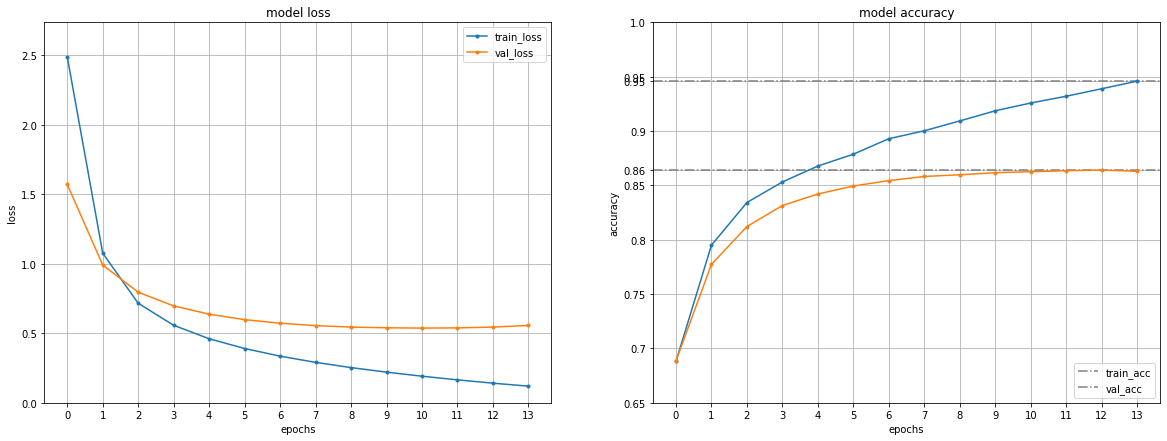

In [ ]:
print_plots(metrics_1)

## BiGRU + FC Model

### Model definition

In [31]:
class BiGRU(Base_RCNN):
    """ Class Modelling the RCNN """
    def __init__(self, n_output=2, hidden=32, **_):
      """
      Args:
          n_output: nunber of output classes for the POS task
          # NO  oov_method : method to address words that are out of vocabulary 
          # NO  num_of_words: number of words to be inputted inside the neural network at a time
          # REPL_W_MAT embedding_model:initial (and final) vector embedding of the words in the known vocabulary

       """
      super(BiGRU, self).__init__(n_output)
      
      self.embedding = nn.Embedding(*WEIGHT_MATRIX.shape)
      self.embedding.weight = nn.Parameter(torch.from_numpy(WEIGHT_MATRIX))
      set_requires_grad_for_layer(self.embedding, False)
      self.gru = nn.GRU(input_size=WEIGHT_MATRIX.shape[1], hidden_size=hidden, bidirectional=True,batch_first=True)
      self.fc = nn.Linear(in_features=hidden*2, out_features=n_output)
      
    def forward(self,x):
      "forward pass of the NN the only input must be an iterable of words"
      x = self.embedding(tensor(x))
      x,_ = self.gru(torch.reshape(x,(1,*x.size())).to(torch.float32))
      return self.fc(x)

### HP tuning

In [ ]:
'''results = tune(
    lambda **pp:  BiGRU(N_OUT_FEATURES, **pp),
    train_dataloader,
    val_dataloader,
    { "optimizer": ["Adam","SGD"],
      "learning_rate": { "Adam": np.linspace(0.00008, 0.0003, num=4), "SGD": np.linspace(0.3, 0.7, num=3)},
      "hidden_size": [64, 128]},
    epochs = 20
)

best_configuration = results[results["F1_score"] == max(results["F1_score"])]
best_configuration
''';

Best configuration: Adam | LR = 0.0001 | Hidden = 256

### Training the model 2 with best Hyperparameters

In [32]:
PRELOAD = False
MODE = Modes.TRAIN_AND_SAVE
SAVED_FNAME = '/content/drive/MyDrive/model2_FINAL'

if MODE is not Modes.LOAD:
  if PRELOAD:
    s_model, s_optim, _ = load_model(SAVED_FNAME, set_to='train')
    print('model loaded from file')
  model_2, metrics_2, cp_pars = train_loop (
      lambda **pp:  (s_model if PRELOAD else BiGRU(N_OUT_FEATURES, **pp)),
      train_dataloader,
      val_dataloader,
      criterion = torch.nn.CrossEntropyLoss(weight=tensor(CLASS_WEIGHTS).to(torch.float32)),
      create_optimizer = (lambda _: s_optim) if PRELOAD else 'default',
      verbose=True,
      params = {'hidden': 256, 'LR_Adam': 0.0001},  #256
      epochs = 25,
      return_last_checkpoint=True
  )
  if MODE is Modes.TRAIN_AND_SAVE:
    checkpoint_model(model_2, SAVED_FNAME, {**cp_pars, 'metrics':metrics_2})
else:
  model_2, _, metrics_2 = load_model(SAVED_FNAME, set_to='train')

| epoch   1 |   500/ 1963 batches | accuracy    0.320
| epoch   1 |  1000/ 1963 batches | accuracy    0.583
| epoch   1 |  1500/ 1963 batches | accuracy    0.703
--------------------------------------------------------------------------------------
  | end of epoch   1 | time: 122.90s | valid accuracy    0.738 | valid loss:   1.189
--------------------------------------------------------------------------------------
| epoch   2 |   500/ 1963 batches | accuracy    0.767
| epoch   2 |  1000/ 1963 batches | accuracy    0.792
| epoch   2 |  1500/ 1963 batches | accuracy    0.811
--------------------------------------------------------------------------------------
  | end of epoch   2 | time: 110.15s | valid accuracy    0.810 | valid loss:   0.824
--------------------------------------------------------------------------------------
| epoch   3 |   500/ 1963 batches | accuracy    0.824
| epoch   3 |  1000/ 1963 batches | accuracy    0.837
| epoch   3 |  1500/ 1963 batches | accuracy    0.

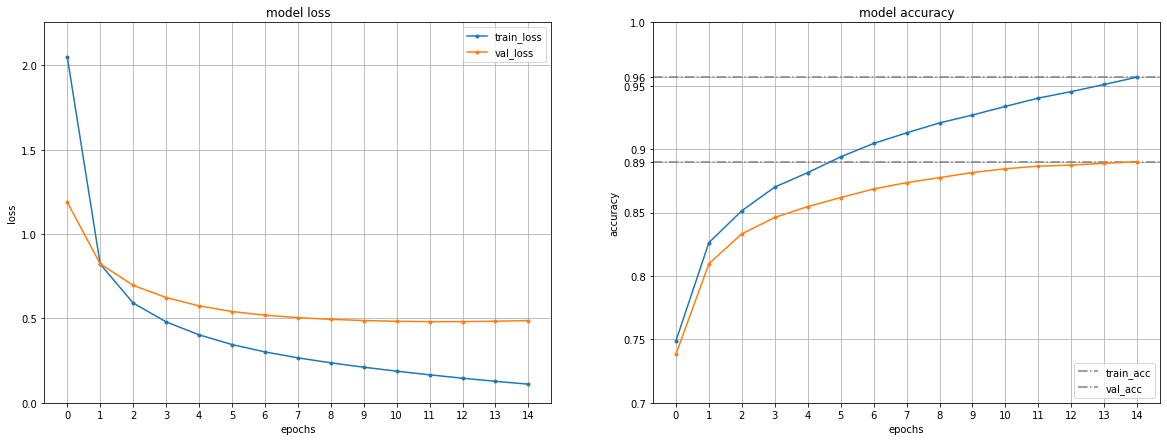

In [33]:
print_plots(metrics_2)

## BiLSTMx2 + FC model

### Model definition

In [ ]:
class BiLSMx2(Base_RCNN):
    """ Class Modelling the RCNN """
    def __init__(self, n_output=2, hidden=32, **_):
      """
      Args:
          n_output: nunber of output classes for the POS task
          # NO  oov_method : method to address words that are out of vocabulary 
          # NO  num_of_words: number of words to be inputted inside the neural network at a time
          # REPL_W_MAT embedding_model:initial (and final) vector embedding of the words in the known vocabulary

       """
      super(BiLSMx2, self).__init__(n_output)
      
      self.embedding = nn.Embedding(*WEIGHT_MATRIX.shape)
      self.embedding.weight = nn.Parameter(torch.from_numpy(WEIGHT_MATRIX))
      set_requires_grad_for_layer(self.embedding, False)
      self.lstm = nn.LSTM(input_size=WEIGHT_MATRIX.shape[1], hidden_size=hidden, num_layers=2, bidirectional=True,batch_first=True)
      self.fc = nn.Linear(in_features=hidden*2, out_features=n_output)
      
    def forward(self,x):
      "fordaward pass of the NN the only input must be an iterable of words"
      x = self.embedding(tensor(x))
      x, _ = self.lstm(torch.reshape(x,(1,*x.size())).to(torch.float32))
      return self.fc(x) 

### HP tuning

In [ ]:
'''results = tune(
    lambda **pp:  BiLSMx2(N_OUT_FEATURES, **pp),
    train_dataloader,
    val_dataloader,
    { "optimizer": ["Adam","SGD"],
      "learning_rate": { "Adam": np.linspace(0.00008, 0.0003, num=4), "SGD": [0.5]},
      "hidden_size": [128,256]},
    epochs = 20
)

best_configuration = results[results["F1_score"] == max(results["F1_score"])]
best_configuration
''';

Best configuration: Adam | LR = 0.0001 | Hidden = 256

### Training model 3 with best Hyperparameters

In [ ]:
PRELOAD = False
MODE = Modes.LOAD
SAVED_FNAME = '/content/drive/MyDrive/model3'

if MODE is not Modes.LOAD:
  if PRELOAD:
    s_model, s_optim, _ = load_model(SAVED_FNAME, set_to='train')
    print('model loaded from file')
  model_3, metrics_3, cp_pars = train_loop (
      lambda **pp:  (s_model if PRELOAD else BiLSMx2(N_OUT_FEATURES, **pp)),
      train_dataloader,
      val_dataloader,
      criterion = torch.nn.CrossEntropyLoss(weight=tensor(CLASS_WEIGHTS).to(torch.float32)),
      create_optimizer = (lambda _: s_optim) if PRELOAD else 'default',
      verbose=True,
      params = {'hidden': 256, 'LR_Adam': 0.0001},  #256
      epochs = 25,
      return_last_checkpoint=True
  )
  if MODE is Modes.TRAIN_AND_SAVE:
    checkpoint_model(model_3, SAVED_FNAME, {**cp_pars, 'metrics':metrics_3})
else:
  model_3, _, metrics_3 = load_model(SAVED_FNAME, set_to='train')

| epoch   1 |   500/ 1963 batches | accuracy    0.121
| epoch   1 |  1000/ 1963 batches | accuracy    0.224
| epoch   1 |  1500/ 1963 batches | accuracy    0.481
--------------------------------------------------------------------------------------
  | end of epoch   1 | time: 201.93s | valid accuracy    0.674 | valid loss:   1.513
--------------------------------------------------------------------------------------
| epoch   2 |   500/ 1963 batches | accuracy    0.706
| epoch   2 |  1000/ 1963 batches | accuracy    0.750
| epoch   2 |  1500/ 1963 batches | accuracy    0.769
--------------------------------------------------------------------------------------
  | end of epoch   2 | time: 245.40s | valid accuracy    0.781 | valid loss:   0.900
--------------------------------------------------------------------------------------
| epoch   3 |   500/ 1963 batches | accuracy    0.806
| epoch   3 |  1000/ 1963 batches | accuracy    0.819
| epoch   3 |  1500/ 1963 batches | accuracy    0.

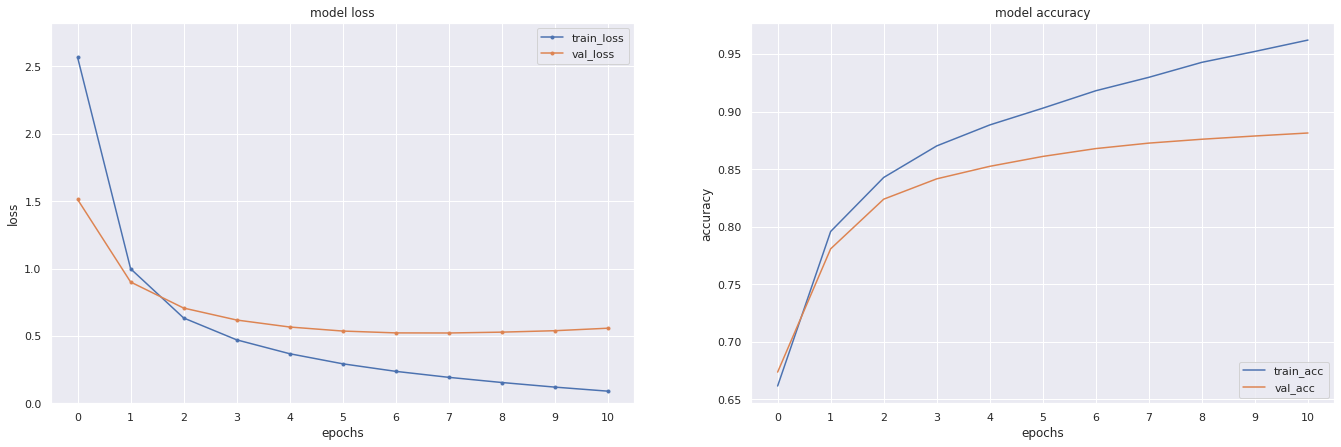

In [ ]:
print_plots(metrics_3)

## BiLSTM + FCx2 model

### Model definition

In [ ]:
class BiLSM_FCx2(Base_RCNN):
    """ Class Modelling the RCNN """
    def __init__(self, n_output, hidden=32, **_):
      """
      Args:
          n_output: nunber of output classes for the POS task
          # NO  oov_method : method to address words that are out of vocabulary 
          # NO  num_of_words: number of words to be inputted inside the neural network at a time
          # REPL_W_MAT embedding_model:initial (and final) vector embedding of the words in the known vocabulary

       """
      super(BiLSM_FCx2, self).__init__(n_output)
      
      self.embedding = nn.Embedding(*WEIGHT_MATRIX.shape)
      self.embedding.weight = nn.Parameter(torch.from_numpy(WEIGHT_MATRIX))
      set_requires_grad_for_layer(self.embedding, False)
      self.lstm = nn.LSTM(input_size=WEIGHT_MATRIX.shape[1], hidden_size=hidden, bidirectional=True,batch_first=True)
      self.fc1 = nn.Linear(in_features=hidden*2, out_features=hidden*2)
      self.relu = torch.nn.ReLU()
      self.fc2 = nn.Linear(in_features=hidden*2, out_features=n_output)
      
    def forward(self, x):
      "fordaward pass of the NN the only input must be an iterable of words"
      x = self.embedding(tensor(x))
      x, _ = self.lstm(torch.reshape(x,(1,*x.size())).to(torch.float32))
      x = self.fc1(x)
      x = self.relu(x)
      return self.fc2(x) 

### HP tuning

In [ ]:
'''results = tune(
    lambda **pp:  BiLSM_FCx2(N_OUT_FEATURES, **pp),
    train_dataloader,
    val_dataloader,
    { "optimizer": ["Adam","SGD"],
      "learning_rate": { "Adam": np.linspace(0.00008, 0.0003, num=4), "SGD": [0.1, 0.01]},
      "hidden_size": [128,256]},
    epochs = 20
)
best_configuration = results[results["F1_score"] == max(results["F1_score"])]
best_configuration
''';

Best configuration: Adam | LR = 0.0001 | Hidden = 256

### Training model 4 with best Hyperparameters

In [ ]:
PRELOAD = False
MODE = Modes.TRAIN_AND_SAVE
SAVED_FNAME = '/content/drive/MyDrive/model4_FINAL'

if MODE is not Modes.LOAD:
  if PRELOAD:
    s_model, s_optim, _ = load_model(SAVED_FNAME, set_to='train')
    print('model loaded from file')
  model_4, metrics_4, cp_pars = train_loop (
      lambda **pp:  (s_model if PRELOAD else BiLSM_FCx2(N_OUT_FEATURES, **pp)),
      train_dataloader,
      val_dataloader,
      criterion = torch.nn.CrossEntropyLoss(weight=tensor(CLASS_WEIGHTS).to(torch.float32)),
      create_optimizer = (lambda _: s_optim) if PRELOAD else 'default',
      verbose=True,
      params = {'hidden': 256, 'LR_Adam': 0.0001},  #256
      epochs = 25,
      return_last_checkpoint=True
  )
  if MODE is Modes.TRAIN_AND_SAVE:
    checkpoint_model(model_4, SAVED_FNAME, {**cp_pars, 'metrics':metrics_4})
else:
  model_4, _, metrics_4 = load_model(SAVED_FNAME, set_to='train')

| epoch   1 |   500/ 1963 batches | accuracy    0.176
| epoch   1 |  1000/ 1963 batches | accuracy    0.464
| epoch   1 |  1500/ 1963 batches | accuracy    0.642
-------------------------------------------------------------------------------------
  | end of epoch   1 | time: 88.44s | valid accuracy    0.703 | valid loss:   1.274
-------------------------------------------------------------------------------------
| epoch   2 |   500/ 1963 batches | accuracy    0.737
| epoch   2 |  1000/ 1963 batches | accuracy    0.770
| epoch   2 |  1500/ 1963 batches | accuracy    0.790
--------------------------------------------------------------------------------------
  | end of epoch   2 | time: 103.95s | valid accuracy    0.790 | valid loss:   0.853
--------------------------------------------------------------------------------------
| epoch   3 |   500/ 1963 batches | accuracy    0.815
| epoch   3 |  1000/ 1963 batches | accuracy    0.825
| epoch   3 |  1500/ 1963 batches | accuracy    0.832

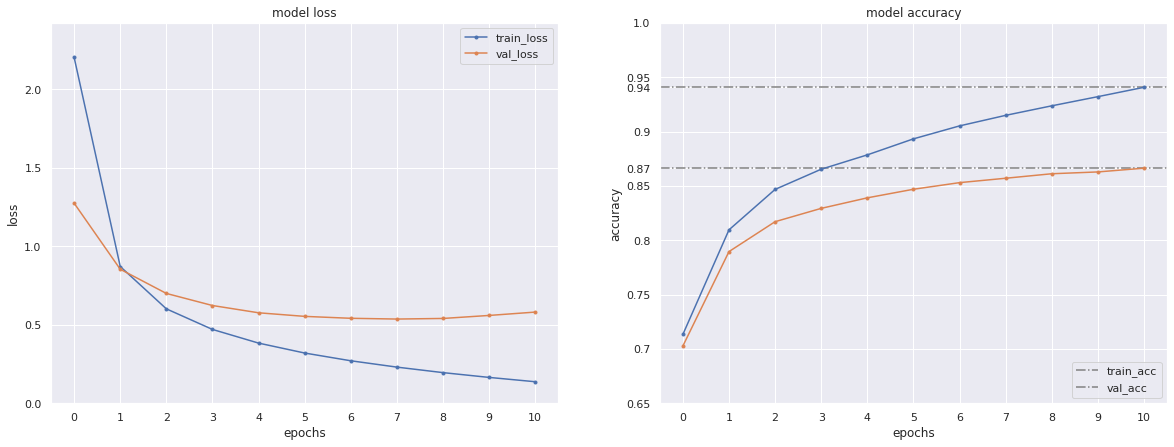

In [ ]:
print_plots(metrics_4)

## Models comparison

In [ ]:
print(f"Model: Baseline (Bi-LSTM + FC) | Validation F1-score macro: {metrics_1['f1_score']}")
print(f"Model: Bi-GRU + FC  | Validation F1-score macro: {metrics_2['f1_score']}")
print(f"Model: BiLSTMx2 + FC  | Validation F1-score macro: {metrics_3['f1_score']}")
print(f"Model: Bi-LSTM_FCx2  | Validation F1-score macro: {metrics_4['f1_score']}")

The 2 best model architectures based on a comparison made on validation set turned out to be:
 *  Bi-GRU + FC model 
 *  BiLSTMx2 + FC model

## Evaluation on the test set

In [ ]:
_, test_accuracy, labels_and_pred_accum = evaluate(test_dataloader, model_2, retain=True)
print(f"Model: Bi-GRU + FC   | Test F1-score macro: {get_f1_score(labels_and_pred_accum, no_punct_labels)} | Test accuracy: {test_accuracy}")

_, test_accuracy, labels_and_pred_accum = evaluate(test_dataloader, model_3, retain=True)
print(f"Model: BiLSTMx2 + FC  | Test F1-score macro: {get_f1_score(labels_and_pred_accum, no_punct_labels)} | Test accuracy: {test_accuracy}")


Model: Bi-GRU + FC   | Test F1-score macro: 0.8174286725402169 | Test accuracy: 0.9013830813766485

Model: BiLSTMx2 + FC  | Test F1-score macro: 0.8166578618056092 | Test accuracy: 0.8927629462849791


## Final Error analysis

We have made this error analysis for all the models and found that it gives very similar results. For this reason, we have decided to leave only the most significant one executed on the best model

We can now introduce test data:

In [34]:
print(end = f'from {len(WORD_TO_POSITION_DEFDICT)}', flush=True)
encoded_test_df,  _ = apply_conversion(test_df, one_hot_dictionary, add_ = 1) # we add 1 random embedding to map UNK.s
print(f' to {len(WORD_TO_POSITION_DEFDICT)}')

test_dataset = CustomTextDataset(encoded_test_df)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

from 400548 to 400676


In [35]:
model_2.update_embeddings()

In [36]:
from pprint import pformat, pprint

revert = lambda dict_: { v:k for k,v in dict_.items() }

POSITION_TO_WORD = revert(WORD_TO_POSITION_DICTIONARY) 

test_loss, _, labels_and_pred_accum = evaluate(test_dataloader, model_2, retain=True)
test_f1_score = get_f1_score(labels_and_pred_accum, no_punct_labels)

print('Some errors:\n',
      pformat([(_,tuple(POSITION_TO_WORD[e] for e in _))  for _ in labels_and_pred_accum if _[0]!=_[1]][:7])
)

Some errors:
 [((29, 21), ('an', 'by')),
 ((27, 2), ("''", '.')),
 ((34, 16), ('but', 'said')),
 ((42, 4), ('which', 'to')),
 ((16, 27), ('said', "''")),
 ((11, 16), ('-', 'said')),
 ((4, 2), ('to', '.'))]


In [37]:
from sklearn.metrics import classification_report

labels_accum, pred_accum = zip(*labels_and_pred_accum)
allowed_labels = list({_ for _ in labels_accum+pred_accum if _ in no_punct_labels})
TAGN_TO_TAG_DICT = revert(one_hot_dictionary)
TNAMES = [ f'{k:2} {TAGN_TO_TAG_DICT[k]:6}' for k in allowed_labels]

print(get_metric_only_tbi(
    labels_and_pred_accum,
    no_punct_labels,
    classification_report,
    ([], {
        'target_names': TNAMES,
        'labels': allowed_labels,
        'zero_division': 0
    })
))

              precision    recall  f1-score   support

    0 -LRB-        0.71      0.67      0.69        18
    2 JJ           0.74      0.76      0.75       918
    3 WRB          0.85      0.92      0.88        24
    4 NN           0.88      0.80      0.84      2381
    5 PRP          0.99      1.00      1.00       192
    6 MD           0.94      1.00      0.97       167
    7 RP           0.55      0.85      0.67        33
    8 TO           1.00      1.00      1.00       386
    9 CC           0.98      1.00      0.99       366
   11 VBG          0.70      0.82      0.76       221
   12 WP           1.00      1.00      1.00        20
   13 VB           0.92      0.97      0.94       403
   14 POS          0.99      1.00      1.00       152
   16 VBD          0.91      0.90      0.90       634
   17 -RRB-        0.55      0.61      0.58        18
   19 LS           0.00      0.00      0.00         0
   20 RBR          0.43      0.40      0.41        15
   21 RB           0.76    

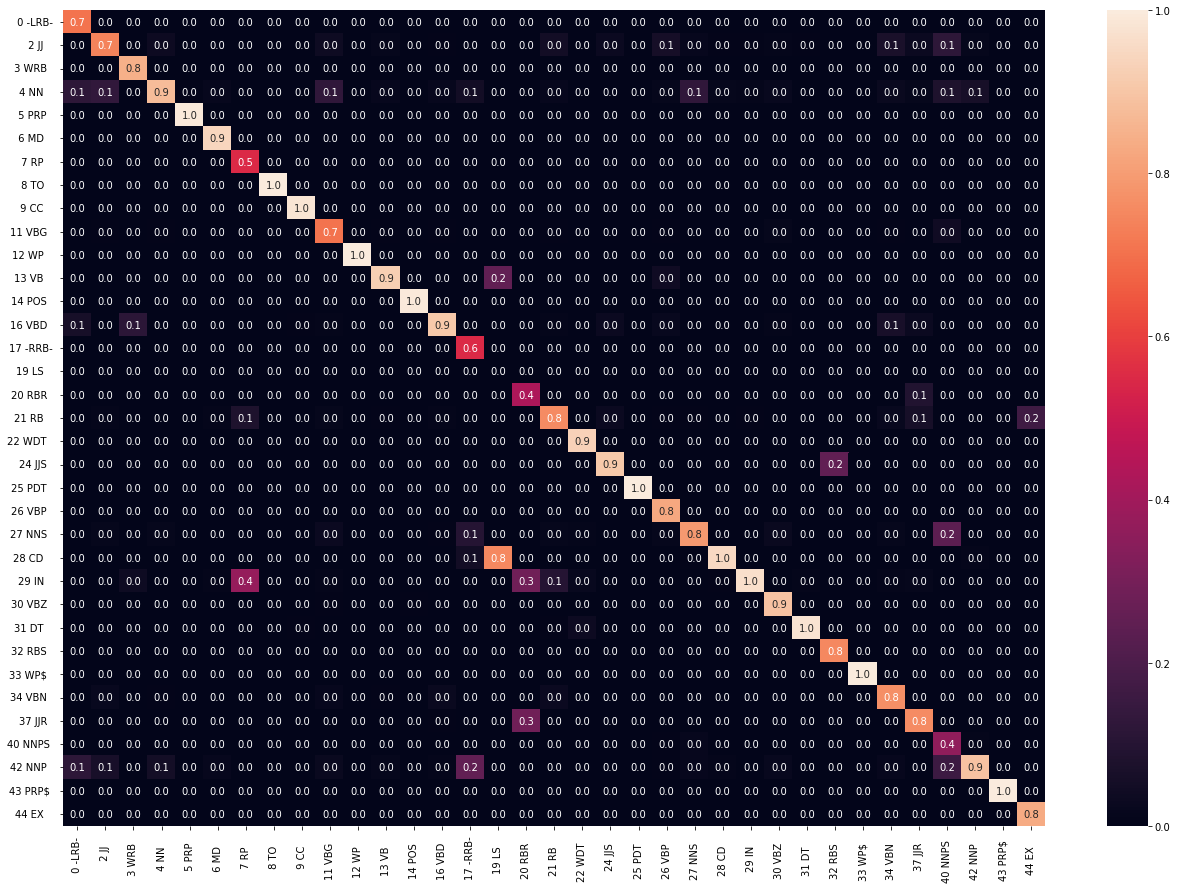

In [38]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import re

cm = get_metric_only_tbi(labels_and_pred_accum, no_punct_labels, confusion_matrix, ([],{'normalize':'pred'}))
#labels = list(set(labels_accum + pred_accum))

plt.figure(figsize = (22,15))
sn.heatmap(
    pd.DataFrame(cm, index=TNAMES, columns=TNAMES),
    annot=True, fmt='.1f')
sn.set(font_scale=1) 

In [39]:
L = re.split(r'\n*\d+\.\s+([^\s]+)\s+(.*)',
'''\
1. 	CC 	Coordinating conjunction
2. 	CD 	Cardinal number
3. 	DT 	Determiner
4. 	EX 	Existential there
5. 	FW 	Foreign word
6. 	IN 	Preposition or subordinating conjunction
7. 	JJ 	Adjective
8. 	JJR 	Adjective, comparative
9. 	JJS 	Adjective, superlative
10. 	LS 	List item marker
11. 	MD 	Modal
12. 	NN 	Noun, singular or mass
13. 	NNS 	Noun, plural
14. 	NNP 	Proper noun, singular
15. 	NNPS 	Proper noun, plural
16. 	PDT 	Predeterminer
17. 	POS 	Possessive ending
18. 	PRP 	Personal pronoun
19. 	PRP$ 	Possessive pronoun
20. 	RB 	Adverb
21. 	RBR 	Adverb, comparative
22. 	RBS 	Adverb, superlative
23. 	RP 	Particle
24. 	SYM 	Symbol
25. 	TO 	to
26. 	UH 	Interjection
27. 	VB 	Verb, base form
28. 	VBD 	Verb, past tense
29. 	VBG 	Verb, gerund or present participle
30. 	VBN 	Verb, past participle
31. 	VBP 	Verb, non-3rd person singular present
32. 	VBZ 	Verb, 3rd person singular present
33. 	WDT 	Wh-determiner
34. 	WP 	Wh-pronoun
35. 	WP$ 	Possessive wh-pronoun
36. 	WRB 	Wh-adverb''')

def aux(L):
  tmp = []
  for e in L:
    tmp.append(e)
    if len(tmp)==3:
      yield tmp[1:]
      tmp=[]

PENNTB = dict(aux(L))

In [40]:
# To visualize output

def try_model(sentence, model, tokenization=r"\'?[^ \t\n\.,;:\!\?\']+|[\.,;:\!\?\']"):
  global WORD_TO_POSITION_DICTIONARY, TAGN_TO_TAG_DICT
  my_sentence = re.findall(tokenization, sentence.lower())
  last = len(WEIGHT_MATRIX)-1
  enc = [WORD_TO_POSITION_DICTIONARY[_] if _ in WORD_TO_POSITION_DICTIONARY else last for _ in my_sentence]
  res = model(enc)
  return [f'{my_sentence[i]:15}'
    f' {(TAGN_TO_TAG_DICT[int(_)] if enc[i]!=last else f"{TAGN_TO_TAG_DICT[int(_)]}[UNK]"):10}'
    f'{(PENNTB[TAGN_TO_TAG_DICT[int(_)]] if TAGN_TO_TAG_DICT[int(_)] in PENNTB else ""):40}'
    for (i,_) in enumerate(res.argmax(2).squeeze())]

try_model('''
Shall I compare thee to a summer’s day?
Thou art more lovely and more temperate:
Rough winds do shake the darling buds of May,
And summer’s lease hath all too short a date;
Sometime too hot the eye of heaven shines,
And often is his gold complexion dimm'd;
And every fair from fair sometime declines,
By chance or nature’s changing course untrimm'd;
But thy eternal summer shall not fade,
Nor lose possession of that fair thou ow’st;
Nor shall death brag thou wander’st in his shade,
When in eternal lines to time thou grow’st:
So long as men can breathe or eyes can see,
So long lives this, and this gives life to thee.'''.replace('’',"'"), model_2)

['shall           MD        Modal                                   ',
 'i               PRP       Personal pronoun                        ',
 'compare         VBP       Verb, non-3rd person singular present   ',
 'thee            VB        Verb, base form                         ',
 'to              TO        to                                      ',
 'a               DT        Determiner                              ',
 'summer          NN        Noun, singular or mass                  ',
 "'s              POS       Possessive ending                       ",
 'day             NN        Noun, singular or mass                  ',
 '?               .                                                 ',
 'thou            NNP       Proper noun, singular                   ',
 'art             NNP       Proper noun, singular                   ',
 'more            RBR       Adverb, comparative                     ',
 'lovely          JJ        Adjective                               ',
 'and 

## Conclusions

The architectures that have reached the best performances in terms of F1-score and
accuracy on the test set are: the Bi-Gru + FC model and the Bi-LSTMx2 + FC model.

Possible extensions of this work could be:
* The addition of learneable embeddings, in order to be able to fine-tune them to our domain.
* Feeding the network with handcrafted features that we know are useful to better perform our
task.
* Trying with a broader spectrum of architectures and with variants of the ones we used. For
example, it would be worth investigating the substitution of the dense layer(s) with time-distributed
dense layer(s).